In [1]:
import sys
sys.path.append("../../")
from simulation_classes.flying_cars import FlyingCars
from simulation_classes.simulation_periodic import SimulationPeriodic
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
"""
シミュレーションの基本的な設定
基本的には ./periodic_simulation.ipynbを参考にしている。
DRONE_NUMについてfor文を回すためのファイル
"""

TOTAL_TIME = 100
time_step = 0.2
simulation_steps = int(TOTAL_TIME / time_step)
scale_factor = 20 
legal_speed = 1.5
real_legal_speed = min(2, legal_speed) * scale_factor * 3.6
TOTAL_DISTANCE = 100
boundary_condition = "PERIODIC"
UPDATE_RULE = "parallel"
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 5 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい

# 先頭の車が前になるように置く(一番後ろの車はx=0でスタート)
def scatter_cars_around(total_distance, car_num, idx, should_scatter=False):
    delta = total_distance / car_num
    return total_distance - delta * (idx+1)

result_obj = {}

min_headway = 10 # 一番密度が高い時の車間距離を [m] で設定
drone_num_for_max_density = int(TOTAL_DISTANCE * scale_factor / min_headway) #その時のドローン台数
print(f"最大ドローン台数：{drone_num_for_max_density}台")
increment = 5

最大ドローン台数：200台


In [3]:
# シミュレーション用の関数

def simulate_with_parameters(**kwagrs):
    helly_params = kwagrs.get("helly_params")
    isRss = helly_params.get("isRss", False)
    simulation_list = []

    for i in range(int(drone_num_for_max_density / increment)):
        DRONE_NUM = (i+1) * increment
        if (DRONE_NUM >206):
            break
        cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                        ycor=0, 
                        v_0=0,
                        legal_speed=legal_speed, 
                        scale_factor=scale_factor,
                        drone_idx = i,
                        helly_params=helly_params,
                        )
                  for i in range(DRONE_NUM)]
        print(DRONE_NUM)
        simulation = SimulationPeriodic(
            TOTAL_TIME=TOTAL_TIME, 
            time_step=time_step, 
            scale_factor=scale_factor,
            drone_list=cars_list,
            TOTAL_DISTANCE=TOTAL_DISTANCE,
            UPDATE_RULE=UPDATE_RULE )
        simulation.run()
        simulation_list.append(simulation)
    
    return simulation_list


### ここからシミュレーション開始。

In [4]:
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor
front_car_brake = FRONT_BRAKE_REAL_WORLD / scale_factor

helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 0.5,
    "isRss":False
  }
rss_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 0.5,
    "isRss":True,
    "front_car_brake": front_car_brake,
    "response_time":0.5 #秒で入れる
  }
simulation_list_helly = simulate_with_parameters(helly_params = helly_params)
simulation_list_rss = simulate_with_parameters(helly_params = rss_params)

5
===PARALLEL実行===
FINISHED
10
===PARALLEL実行===
FINISHED
15
===PARALLEL実行===
FINISHED
20
===PARALLEL実行===
FINISHED
25
===PARALLEL実行===
FINISHED
30
===PARALLEL実行===
FINISHED
35
===PARALLEL実行===
FINISHED
40
===PARALLEL実行===
FINISHED
45
===PARALLEL実行===
FINISHED
50
===PARALLEL実行===
FINISHED
55
===PARALLEL実行===
FINISHED
60
===PARALLEL実行===
FINISHED
65
===PARALLEL実行===
FINISHED
70
===PARALLEL実行===
FINISHED
75
===PARALLEL実行===
FINISHED
80
===PARALLEL実行===
FINISHED
85
===PARALLEL実行===
FINISHED
90
===PARALLEL実行===
FINISHED
95
===PARALLEL実行===
FINISHED
100
===PARALLEL実行===
FINISHED
105
===PARALLEL実行===
FINISHED
110
===PARALLEL実行===
FINISHED
115
===PARALLEL実行===
FINISHED
120
===PARALLEL実行===
FINISHED
125
===PARALLEL実行===
FINISHED
130
===PARALLEL実行===
FINISHED
135
===PARALLEL実行===
FINISHED
140
===PARALLEL実行===
FINISHED
145
===PARALLEL実行===
FINISHED
150
===PARALLEL実行===
FINISHED
155
===PARALLEL実行===
FINISHED
160
===PARALLEL実行===
FINISHED
165
===PARALLEL実行===
FINISHED
170
===PARALLEL実行===
FINISHED


### ここからは解析に入る

In [5]:
def analysis(**kwagrs):
    dataList = []
    simulation_list = kwagrs.get("simulation_list",[])
    isRss = kwagrs.get("isRss",False)
    model = "RSS" if isRss else "Helly"
    for simulation in simulation_list:
        cars = simulation.drone_list
        # 流量を計算する
        velocity_list = []
        for car in cars:
            snap_frame = int(simulation_steps * 0.95)
            velocity_list.append(car.v_xList[snap_frame])
        mean_velocity = np.mean(np.array(velocity_list)) * scale_factor

        # 密度：1km当たりの台数
        rho = len(cars) / (TOTAL_DISTANCE * scale_factor)  * 1000
        flow = rho * mean_velocity

        # プロット用に保存
        dataToSave = {
            "density":rho,
            "flow":flow,
            "mean_velocity":mean_velocity,
            "start_position":"unscattered",
            "drone_num":len(cars),
            "model":model
        }
        dataList.append(dataToSave)

    df = pd.DataFrame(dataList)
    return df


### グラフのVisualization

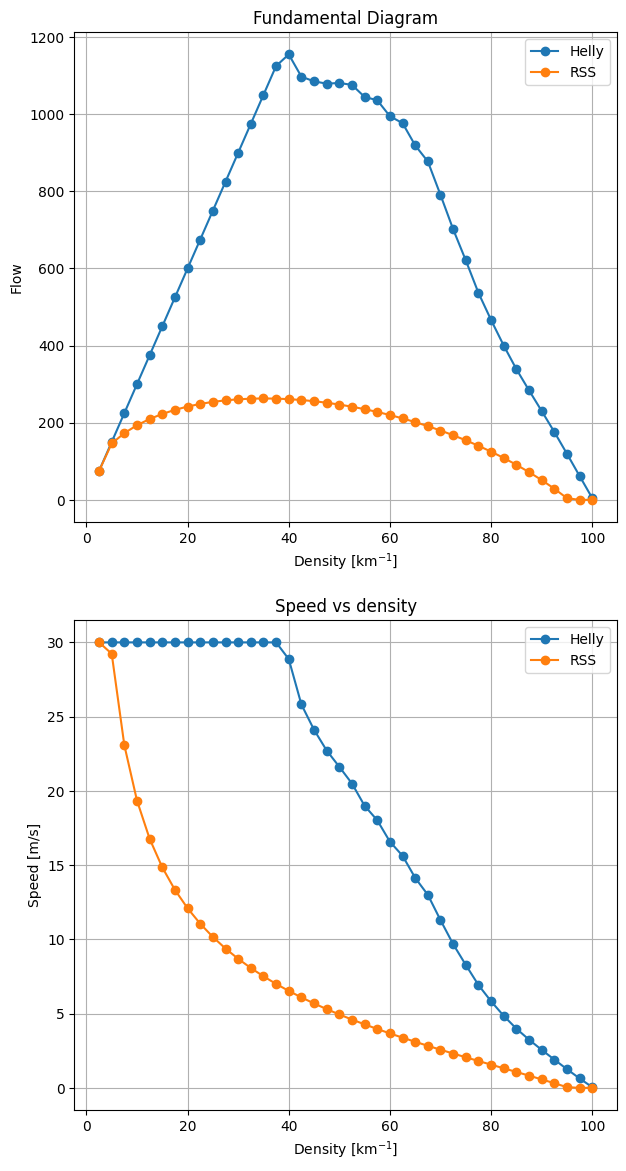

    density         flow  mean_velocity start_position  drone_num  model
0       2.5    75.000000      30.000000    unscattered          5  Helly
1       5.0   150.000000      30.000000    unscattered         10  Helly
2       7.5   225.000000      30.000000    unscattered         15  Helly
3      10.0   300.000000      30.000000    unscattered         20  Helly
4      12.5   375.000000      30.000000    unscattered         25  Helly
5      15.0   450.000000      30.000000    unscattered         30  Helly
6      17.5   525.000000      30.000000    unscattered         35  Helly
7      20.0   600.000000      30.000000    unscattered         40  Helly
8      22.5   675.000000      30.000000    unscattered         45  Helly
9      25.0   750.000000      30.000000    unscattered         50  Helly
10     27.5   825.000000      30.000000    unscattered         55  Helly
11     30.0   900.000000      30.000000    unscattered         60  Helly
12     32.5   975.000000      30.000000    unscatte

In [6]:
df_helly = analysis(simulation_list=simulation_list_helly)
df_rss = analysis(simulation_list=simulation_list_rss, isRss=True)

# 折れ線グラフを描画
plt.figure(figsize=(7, 14))
plt.subplot(2, 1, 1)
plt.plot(df_helly["density"], df_helly["flow"], marker='o', label="Helly")
plt.plot(df_rss["density"], df_rss["flow"], marker='o', label="RSS")
plt.xlabel(r'Density [km$^{-1}$]')
plt.ylabel('Flow')
plt.title('Fundamental Diagram')
plt.grid(True)
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(df_helly["density"], df_helly["mean_velocity"], marker='o', label="Helly")
plt.plot(df_rss["density"], df_rss["mean_velocity"], marker='o', label="RSS")
plt.xlabel(r'Density [km$^{-1}$]')
plt.ylabel('Speed [m/s]')
plt.title('Speed vs density')
plt.grid(True)
plt.legend()
plt.show()

print(df_helly.head(20))
print(df_rss.head(20))

In [ ]:
# ここからdebug開始 


In [3]:
# ここからdebug開始 
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor
front_car_brake = FRONT_BRAKE_REAL_WORLD / scale_factor

rss_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "lambda_1": 0.2,
    "lambda_2": 0,
    "d": 0.499,
    "T_des": 0.5,
    "isRss":True,
    "front_car_brake": front_car_brake,
    "response_time":0.5 #秒で入れる
  }

DRONE_NUM = 150
    
cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                ycor=0, 
                v_0=0,
                legal_speed=legal_speed, 
                scale_factor=scale_factor,
                drone_idx = i,
                helly_params=rss_params,
                )
          for i in range(DRONE_NUM)]
print(DRONE_NUM)
simulation = SimulationPeriodic(
  TOTAL_TIME=20, 
  time_step=time_step, 
  scale_factor=scale_factor,
  drone_list=cars_list,
  TOTAL_DISTANCE=TOTAL_DISTANCE,
  UPDATE_RULE=UPDATE_RULE )
simulation.run()

drones = simulation.drone_list
print(drones[0].v_xList)
print(len(drones[0].v_xList))

150
===PARALLEL実行===
t= 0
Drone ID= 0
Next Speed= 0.0057021971077580065
Drone ID= 1
Next Speed= 0.005705409703244366
Drone ID= 2
Next Speed= 0.005705412413673258
Drone ID= 3
Next Speed= 0.005705412415960443
Drone ID= 4
Next Speed= 0.0057054124159618145
Drone ID= 5
Next Speed= 0.005705412415962372
Drone ID= 6
Next Speed= 0.005705412415962372
Drone ID= 7
Next Speed= 0.005705412415961816
Drone ID= 8
Next Speed= 0.005705412415962372
Drone ID= 9
Next Speed= 0.005705412415962372
Drone ID= 10
Next Speed= 0.005705412415961816
Drone ID= 11
Next Speed= 0.005705412415962372
Drone ID= 12
Next Speed= 0.005705412415962372
Drone ID= 13
Next Speed= 0.005705412415961816
Drone ID= 14
Next Speed= 0.005705412415962372
Drone ID= 15
Next Speed= 0.005705412415962372
Drone ID= 16
Next Speed= 0.005705412415961816
Drone ID= 17
Next Speed= 0.005705412415962372
Drone ID= 18
Next Speed= 0.005705412415962372
Drone ID= 19
Next Speed= 0.005705412415961816
Drone ID= 20
Next Speed= 0.005705412415962372
Drone ID= 21
Nex